# ЛАБОРАТОРНАЯ РАБОТА № 2.4. Модели авторегрессии временных рядов

In [1]:
## Подключение пакетов
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.stats.diagnostic import acorr_ljungbox

from itertools import product

import pmdarima as pm


In [2]:
def plot_ts(data):
    '''
    Построение графика временного ряда с автокорреляциями
    '''
    fig, axs = plt.subplots(
        nrows=3, # число колонок
        sharey=False,
        figsize = (12,6),
        layout="constrained"
    )
    axs[0].plot(data)
    axs[0].set_title('Data')
    plot_acf(data, ax=axs[1])
    plot_pacf(data, ax=axs[2])



## 1. Исследование моделей авотрегрессии и скользящего среднего

### 1.1. Семинарская часть

В качестве примера исследуем синтетический MA-процесс, заданные  функцией
$$
    y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t
$$
где $\varepsilon_t \sim N(0,1)$ - гауссов белый шум.

In [39]:
### Сгенерируем гауссов белый шум
rng=np.random.RandomState(42) # Фиксируем state генератора случайных чисел
eps = rng.normal(0, 1, 365*3) # три года наблюдений :)

### Зададим математическое ожидание
mu = 50

### Сформируем ряд
Y = [mu + 0.4*eps[t-1] + 0.3*eps[t-2] + eps[t] for t in range(2,len(eps))]
Y = pd.Series(Y)


In [40]:
### Как обычно выделим обучающую и тестовую выборки:
test_ratio = 0.2
test_start = int(len(Y)*(1-test_ratio))
test_end = len(Y)-1

train_data = Y[:test_start]
test_data = Y[test_start:]

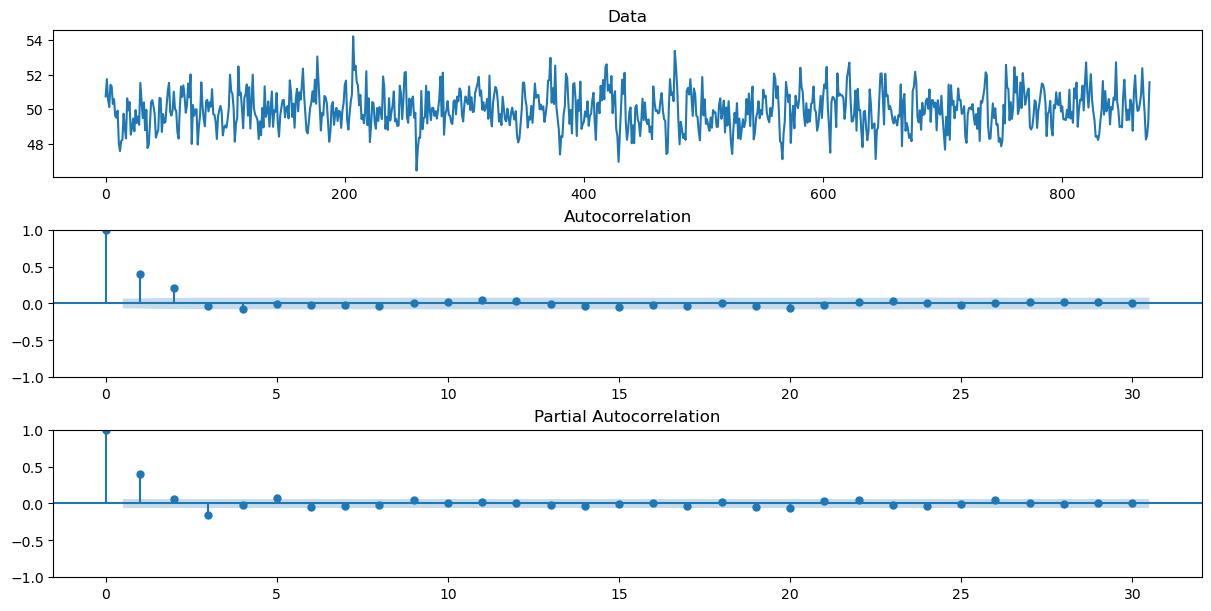

In [42]:
plot_ts(train_data)

* Из графика частной корреляционной функции PACF видим, что статистически значимые лаги:0,1,3. Поэтому нашу модель можно описать как AR-процесс порядка не более чем 3.
* Аналогично, из графика автокорреляционной функции ACF видим, что статистически значимы только первые три лага: 0,1,2 на уровне значимости 0.05 

Таким образом, можно смоделировать наш временной ряд как MA(2)-модель или как AR(3)-модель

Для моделирования будем использовать общую модель $ARIMA(p,d,q)$.

Имеем:
* $AR(p) = ARIMA(p,0,0)$
* $MA(q) = ARIMA(0,0,q)$


In [43]:
# Обучим модели:
ar_model = ARIMA(train_data, order=(3,0,0)).fit()
ma_model = ARIMA(train_data, order=(0,0,2)).fit()

In [44]:
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  874
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1223.791
Date:                Thu, 29 May 2025   AIC                           2457.581
Time:                        16:15:28   BIC                           2481.447
Sample:                             0   HQIC                          2466.711
                                - 874                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0048      0.051    977.407      0.000      49.905      50.105
ar.L1          0.3852      0.034     11.402      0.000       0.319       0.451
ar.L2          0.1237      0.038      3.291      0.0

In [ ]:
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  874
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1262.182
Date:                Wed, 21 Feb 2024   AIC                           2532.365
Time:                        05:45:29   BIC                           2551.457
Sample:                             0   HQIC                          2539.669
                                - 874                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0073      0.059    845.578      0.000      49.891      50.123
ma.L1          0.4211      0.032     13.124      0.000       0.358       0.484
ma.L2          0.2799      0.034      8.116      0.0

Итак, мы смоделировали процесс получив:
* $AR(3)\colon \hat{y}_t = 50 + 0.38 \hat{y}_{t-1}+ 0.12 \hat{y}_{t-2} -0.16\hat{y}_{t-3}$
* $MA(2)\colon \hat{y}_t = 50 + 0.42\varepsilon_{t-1} + 0.28\varepsilon_{t-2}$

Обратим внимание, что все коэффициенты имеют p-значение меньшее, чем 0.005 (столбец `P>|z|`), то есть значимы на уровне 0.005.

(При перезапуске выписанные уравнения могут не соответствовать вычисленным значениям)

Посмотрим на распределенеие остатков и их автокорреляцию:

[]

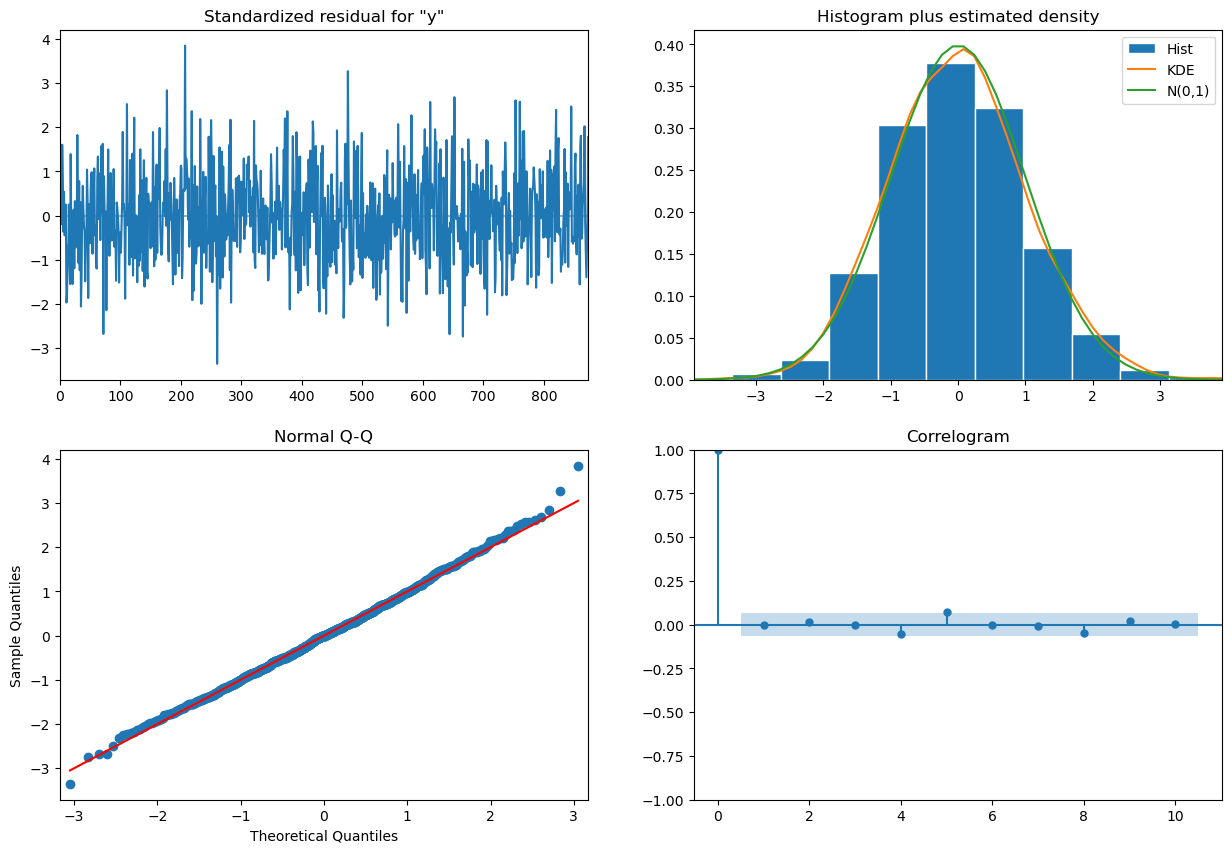

In [45]:
ar_model.plot_diagnostics(figsize=(15, 10))
plt.plot()

[]

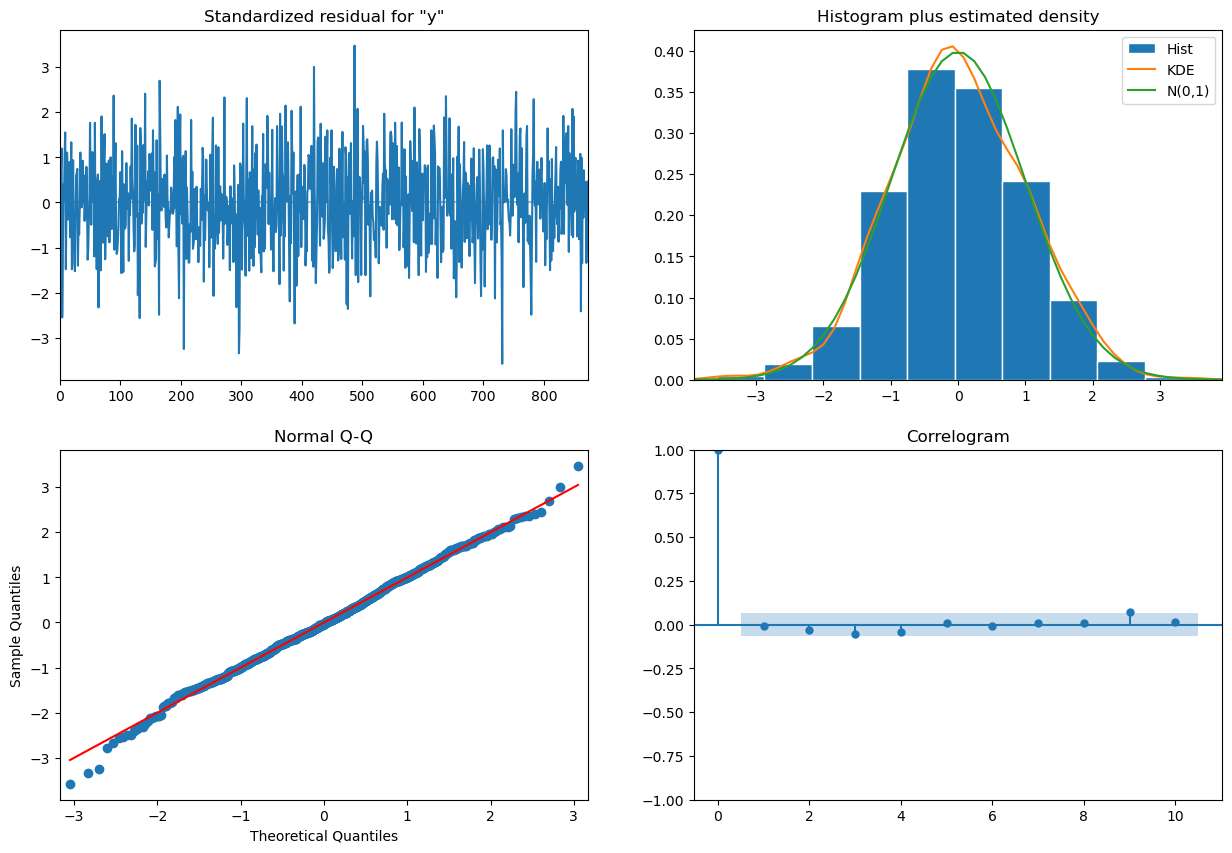

In [ ]:
ma_model.plot_diagnostics(figsize=(15, 10))
plt.plot()

Видим, что остатки имеют нормальное распределение. 
Коррелограмма соответсвует белому шуму.

Выполним прогнозирование

In [46]:
ar_predictions = ar_model.predict(start=test_start, end=test_end, dynamic=False)
ma_predictions = ma_model.predict(start=test_start, end=test_end, dynamic=False)

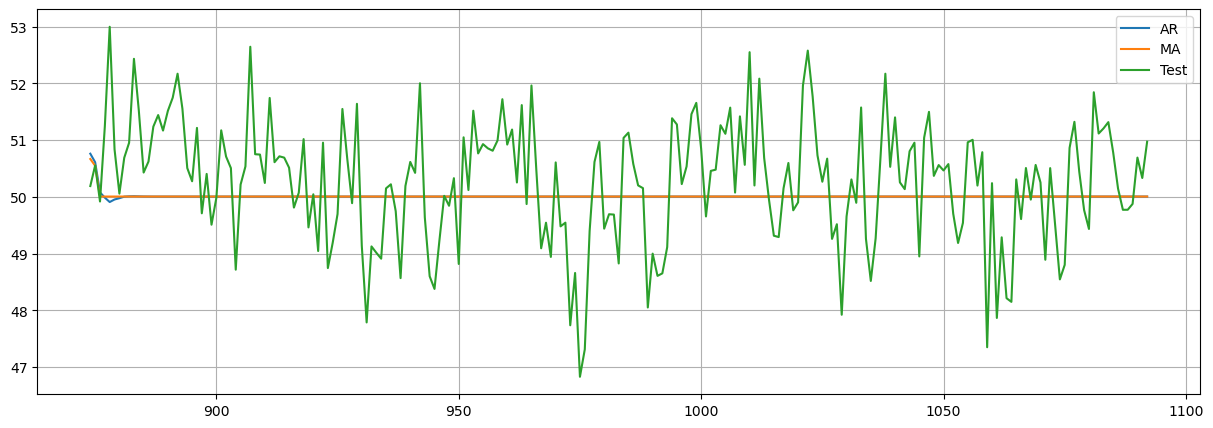

In [47]:
# Изобразим результаты прогнозирования
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(15, 5))
ax.plot(ar_predictions, label='AR')
ax.plot(ma_predictions, label='MA')
ax.plot(test_data,label='Test')
ax.legend()
ax.grid()
plt.show()

Ожидаемо модель не знает ничего о новых данных и через три шага выходит на среднее.

Давайте будем прогнозировать на день вперед и передавать актуальные данные:

In [48]:
ar_forecast = pd.Series(0. ,index = test_data.index)
for  i in test_data.index:
    ar_forecast[i] = ar_model.forecast(1).values[0] # прогноз
    ar_model = ar_model.append(test_data.loc[[i]],refit=False) # пополнение 

In [49]:
ma_forecast = pd.Series(0. ,index = test_data.index)
for  i in test_data.index:
    ma_forecast[i] = ma_model.forecast(1).values[0]# прогноз
    ma_model = ma_model.append(test_data.loc[[i]],refit=False) # пополнение 

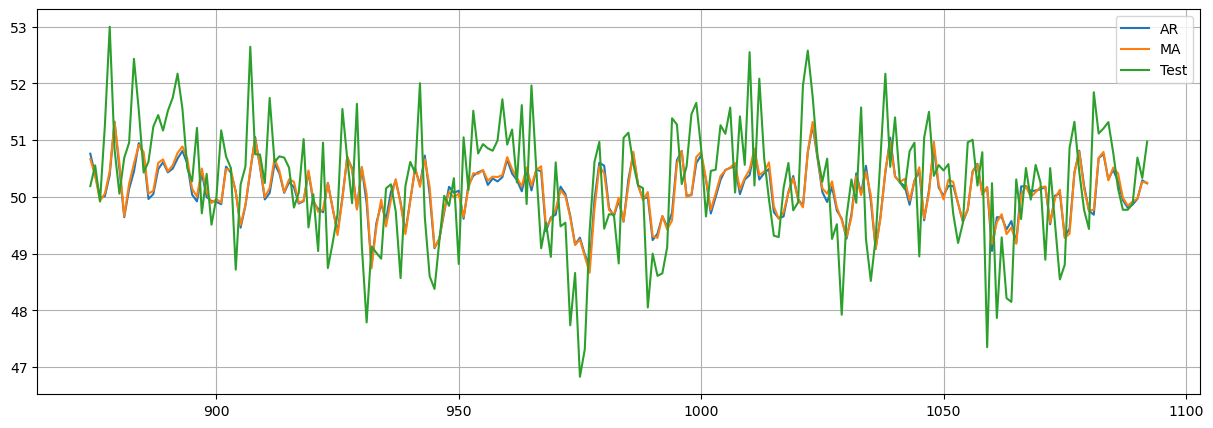

In [50]:
# Изобразим результаты прогнозирования
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(15, 5))
ax.plot(ar_forecast, label='AR')
ax.plot(ma_forecast, label='MA')
ax.plot(test_data,label='Test')
ax.legend()
ax.grid()
plt.show()

Другое дело!

Вычислим ошибку прогноза:

In [51]:
mean_squared_error(test_data,ar_forecast)

0.9490607863907484

In [52]:
mean_squared_error(test_data,ma_forecast)

0.929901854944239

Итак, случайную последовательность спрогнозировать удается.

### 1.2. Задание 1
1. Построить выборку из AR-процесса $y_{t} = 0.3y_{t-1} - 0.1y_{t-2} + 5 + \varepsilon_t$. Можно ли представить его MA-моделью? если можно - какого порядка?
2. Исследовать как меняются коррелограммы AR(p) и MA(q) процессов при изменении $p$ и $q$. Расмотреть разные значения до 5.
3. Рассмотреть временные ряды построенные как суммы уже рассмотренных $AR(p) + MA(q) = ARMA(p,q)$. Можно ли по их коррелограммам оценить $p$ и $q$? 


## 2. Моделирование с помощью SARIMA

### 2.1. Семинарская часть
* Эмпирические правила для определения гаперпараметров модели SARIMA:
https://people.duke.edu/~rnau/arimrule.htm


In [3]:
monthly_australian_wine_sales = [
    ['1980-01-01',15136],
    ['1980-02-01',16733],
    ['1980-03-01',20016],
    ['1980-04-01',17708],
    ['1980-05-01',18019],
    ['1980-06-01',19227],
    ['1980-07-01',22893],
    ['1980-08-01',23739],
    ['1980-09-01',21133],
    ['1980-10-01',22591],
    ['1980-11-01',26786],
    ['1980-12-01',29740],
    ['1981-01-01',15028],
    ['1981-02-01',17977],
    ['1981-03-01',20008],
    ['1981-04-01',21354],
    ['1981-05-01',19498],
    ['1981-06-01',22125],
    ['1981-07-01',25817],
    ['1981-08-01',28779],
    ['1981-09-01',20960],
    ['1981-10-01',22254],
    ['1981-11-01',27392],
    ['1981-12-01',29945],
    ['1982-01-01',16933],
    ['1982-02-01',17892],
    ['1982-03-01',20533],
    ['1982-04-01',23569],
    ['1982-05-01',22417],
    ['1982-06-01',22084],
    ['1982-07-01',26580],
    ['1982-08-01',27454],
    ['1982-09-01',24081],
    ['1982-10-01',23451],
    ['1982-11-01',28991],
    ['1982-12-01',31386],
    ['1983-01-01',16896],
    ['1983-02-01',20045],
    ['1983-03-01',23471],
    ['1983-04-01',21747],
    ['1983-05-01',25621],
    ['1983-06-01',23859],
    ['1983-07-01',25500],
    ['1983-08-01',30998],
    ['1983-09-01',24475],
    ['1983-10-01',23145],
    ['1983-11-01',29701],
    ['1983-12-01',34365],
    ['1984-01-01',17556],
    ['1984-02-01',22077],
    ['1984-03-01',25702],
    ['1984-04-01',22214],
    ['1984-05-01',26886],
    ['1984-06-01',23191],
    ['1984-07-01',27831],
    ['1984-08-01',35406],
    ['1984-09-01',23195],
    ['1984-10-01',25110],
    ['1984-11-01',30009],
    ['1984-12-01',36242],
    ['1985-01-01',18450],
    ['1985-02-01',21845],
    ['1985-03-01',26488],
    ['1985-04-01',22394],
    ['1985-05-01',28057],
    ['1985-06-01',25451],
    ['1985-07-01',24872],
    ['1985-08-01',33424],
    ['1985-09-01',24052],
    ['1985-10-01',28449],
    ['1985-11-01',33533],
    ['1985-12-01',37351],
    ['1986-01-01',19969],
    ['1986-02-01',21701],
    ['1986-03-01',26249],
    ['1986-04-01',24493],
    ['1986-05-01',24603],
    ['1986-06-01',26485],
    ['1986-07-01',30723],
    ['1986-08-01',34569],
    ['1986-09-01',26689],
    ['1986-10-01',26157],
    ['1986-11-01',32064],
    ['1986-12-01',38870],
    ['1987-01-01',21337],
    ['1987-02-01',19419],
    ['1987-03-01',23166],
    ['1987-04-01',28286],
    ['1987-05-01',24570],
    ['1987-06-01',24001],
    ['1987-07-01',33151],
    ['1987-08-01',24878],
    ['1987-09-01',26804],
    ['1987-10-01',28967],
    ['1987-11-01',33311],
    ['1987-12-01',40226],
    ['1988-01-01',20504],
    ['1988-02-01',23060],
    ['1988-03-01',23562],
    ['1988-04-01',27562],
    ['1988-05-01',23940],
    ['1988-06-01',24584],
    ['1988-07-01',34303],
    ['1988-08-01',25517],
    ['1988-09-01',23494],
    ['1988-10-01',29095],
    ['1988-11-01',32903],
    ['1988-12-01',34379],
    ['1989-01-01',16991],
    ['1989-02-01',21109],
    ['1989-03-01',23740],
    ['1989-04-01',25552],
    ['1989-05-01',21752],
    ['1989-06-01',20294],
    ['1989-07-01',29009],
    ['1989-08-01',25500],
    ['1989-09-01',24166],
    ['1989-10-01',26960],
    ['1989-11-01',31222],
    ['1989-12-01',38641],
    ['1990-01-01',14672],
    ['1990-02-01',17543],
    ['1990-03-01',25453],
    ['1990-04-01',32683],
    ['1990-05-01',22449],
    ['1990-06-01',22316],
    ['1990-07-01',27595],
    ['1990-08-01',25451],
    ['1990-09-01',25421],
    ['1990-10-01',25288],
    ['1990-11-01',32568],
    ['1990-12-01',35110],
    ['1991-01-01',16052],
    ['1991-02-01',22146],
    ['1991-03-01',21198],
    ['1991-04-01',19543],
    ['1991-05-01',22084],
    ['1991-06-01',23816],
    ['1991-07-01',29961],
    ['1991-08-01',26773],
    ['1991-09-01',26635],
    ['1991-10-01',26972],
    ['1991-11-01',30207],
    ['1991-12-01',38687],
    ['1992-01-01',16974],
    ['1992-02-01',21697],
    ['1992-03-01',24179],
    ['1992-04-01',23757],
    ['1992-05-01',25013],
    ['1992-06-01',24019],
    ['1992-07-01',30345],
    ['1992-08-01',24488],
    ['1992-09-01',25156],
    ['1992-10-01',25650],
    ['1992-11-01',30923],
    ['1992-12-01',37240],
    ['1993-01-01',17466],
    ['1993-02-01',19463],
    ['1993-03-01',24352],
    ['1993-04-01',26805],
    ['1993-05-01',25236],
    ['1993-06-01',24735],
    ['1993-07-01',29356],
    ['1993-08-01',31234],
    ['1993-09-01',22724],
    ['1993-10-01',28496],
    ['1993-11-01',32857],
    ['1993-12-01',37198],
    ['1994-01-01',13652],
    ['1994-02-01',22784],
    ['1994-03-01',23565],
    ['1994-04-01',26323],
    ['1994-05-01',23779],
    ['1994-06-01',27549],
    ['1994-07-01',29660],
    ['1994-08-01',23356],
]

In [4]:
ts = pd.DataFrame(data =monthly_australian_wine_sales,  columns = ['month','sales'])
ts['month'] = pd.to_datetime(ts['month'])
ts.set_index('month',inplace=True)
ts = ts.resample('M').sum()['sales']


#Выделим отложенную выборку
ts_test = ts.iloc[-12:]
ts = ts.iloc[:-12]

ts.head()


month
1980-01-31    15136
1980-02-29    16733
1980-03-31    20016
1980-04-30    17708
1980-05-31    18019
Freq: M, Name: sales, dtype: int64

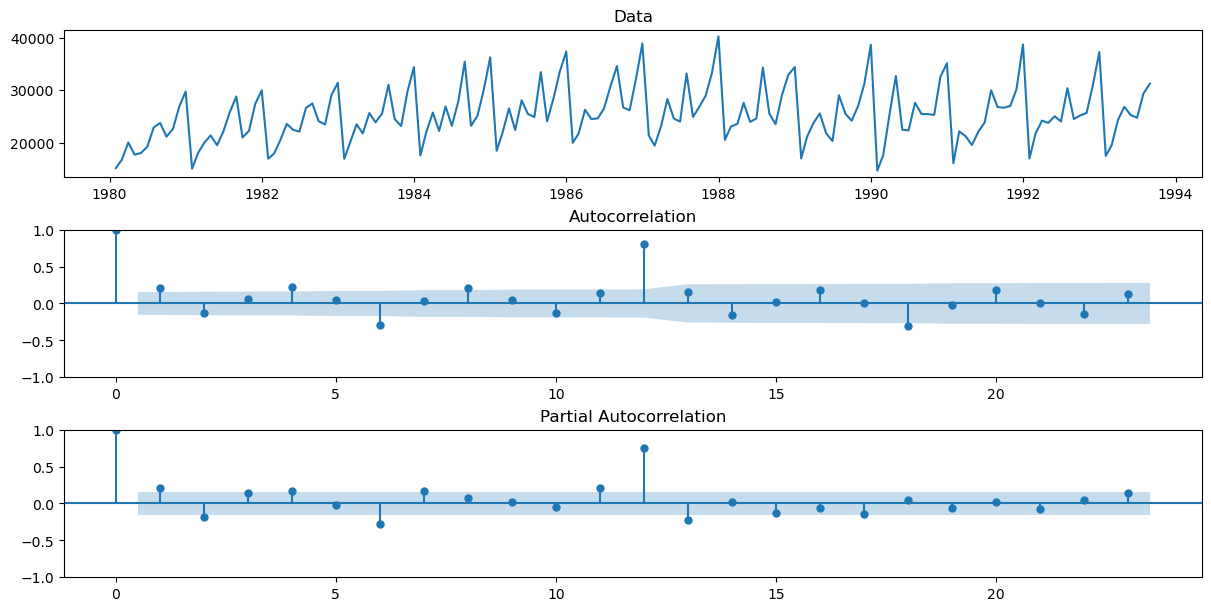

In [5]:
plot_ts(ts)

Наблюдается 
- выраженная сезонность с периодом 12 месяцев
- наличие цикличности

Убедимся в нестационарности данных 

Воспользуемся тестом на единичный корень KPSS

* Нулевая гипотеза $H_0$ - корень отсутствует (ряд стационарен)
* Альтернативная гипотеза $H_1$ - корень есть (ряд нестационарен)

Функция `kpss` возвращает кортеж `(kpss_stat, p_value, lags, crit)`
- `kpss_stat` - Наблюдаемое значение статистики
- `p_value` - p-значение (интерполированное)
- `lags` - число наблюдаемых лагов ряда
- `crit` таблица критических значений статистики

In [6]:
kpss(ts, 
     nlags='legacy',
     regression='c', # Нулевая гипотеза - ряд стационарен относительно константы
     )

(0.5611587012241513,
 0.027892184408974917,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value < 0.05. Гипотеза о стационарности отклоняется на 5% уровне значимости

Ряд имеет выраженную сезонность, поэтому моделирование его можно реализовать 
с помощью модели ARIMA, примененной к ряду сезонных разностей
или с помощью SARIMA



### Модель ARIMA для ряда сезонных разностей

Удалим сезонность выполнив сезонное дифференцирование:

 p-значение не меньше: 0.050192270747408146


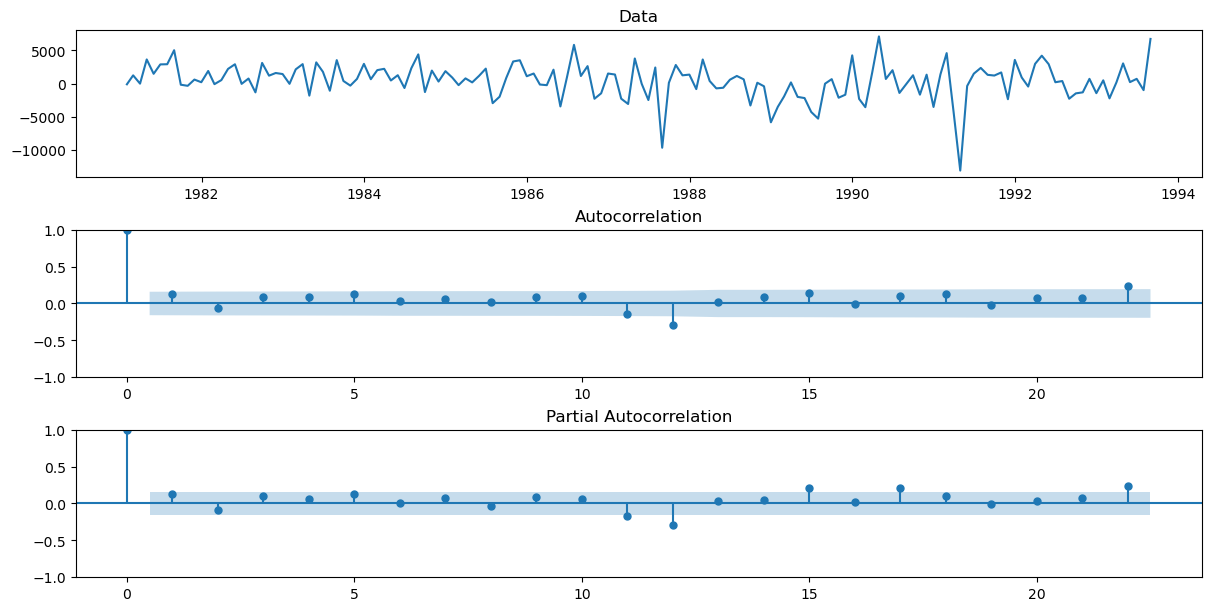

In [7]:
diff_ts = ts.diff(12)[12:]
pval = kpss(diff_ts, nlags='legacy')[1]
print(f' p-значение не меньше: {pval}')
plot_ts(diff_ts)

p-значение для ряда сезонных разностей пограничное. 
Формально, можно считать, что ряд стационарен и d=0, 
Но мы выполним еще один шаг дифференцирования
взяв $d=1$ и вычислив конечную разность

/tmp/ipykernel_18077/4216258978.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  pval = kpss(diff2_ts, nlags='legacy')[1];


 p-значение не меньше: 0.1


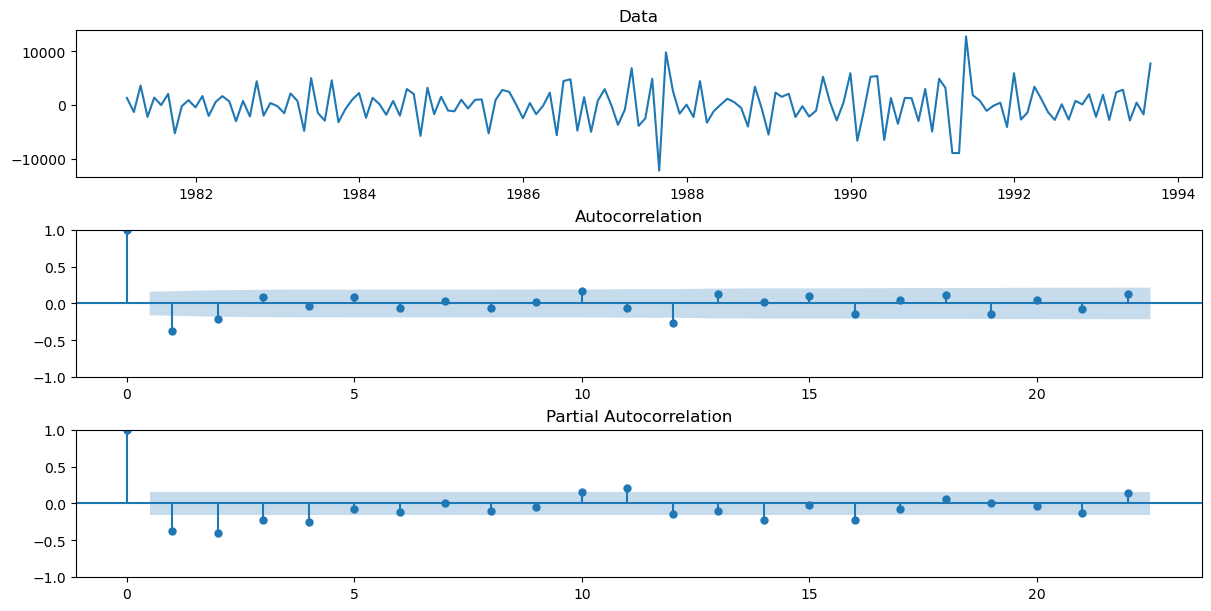

In [8]:
diff2_ts = diff_ts.diff(1)[1:]
pval = kpss(diff2_ts, nlags='legacy')[1];
print(f' p-значение не меньше: {pval}')
plot_ts(diff2_ts)

Итак, P-значение превосходит 0.05, значит, нет оснований отвергать гипотезу о стационарности ряда

Принимаем $d=1$

Переходим к оценке параметров $p$ и $q$
- Графики ACF и PACF - затухающие
- На ACF значимы лаги 1, 2 и 12.  величину $q$ берем в окрестности 1.
- на PACF — 1-4 и 12.  Величину $p$ берем в окрестности 4.

Таким образом можно рассмотреть модели 
- ARIMA(4,1,0)
- ARIMA(0,1,2)
Если p,q >0, то функции автокорреляции не дают информации о модели, поэтому будем искать модель перебором по сетке минимизируя BIC в окрестности модели ARIMA(4,1,1)

In [9]:
BICs = []
for order in product([2,3,4,5],[1], [0,1,2,3]):
    try:
        print(order)
        arima = ARIMA(diff_ts.values, order=order).fit(method_kwargs={'maxiter': 500})
        BICs.append(list(order)+[arima.bic])
    except:
        pass
BICs = pd.DataFrame(data=BICs, columns=['p','d','q','bic']).sort_values('bic')
BICs

(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)


/home/dima/.conda/envs/stat/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dima/.conda/envs/stat/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 0)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(5, 1, 0)
(5, 1, 1)
(5, 1, 2)
(5, 1, 3)


,p,d,q,bic
2,2,1,2,2819.123512
3,2,1,3,2823.391954
6,3,1,2,2823.562935
1,2,1,1,2825.251622
5,3,1,1,2827.407401
7,3,1,3,2828.307156
11,4,1,3,2829.883691
10,4,1,2,2829.969689
9,4,1,1,2833.342212
14,5,1,2,2834.292431


Оптимальная модель ARIMA(2,1,2) 

In [10]:
arima = ARIMA(diff_ts.values, order=(2,1,2)).fit(method_kwargs={'maxiter': 500})
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  152
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1397.019
Date:                Thu, 29 May 2025   AIC                           2804.037
Time:                        15:25:35   BIC                           2819.124
Sample:                             0   HQIC                          2810.166
                                - 152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8248      0.082    -10.109      0.000      -0.985      -0.665
ar.L2         -0.0204      0.095     -0.214      0.831      -0.207       0.167
ma.L1          0.0489      0.082      0.594      0.5

Обратим внимание, что p-значение для коэффициентов ar.L2 и ma.L1 статистически незначимы, то есть нет оснований считать их отличными от нуля

Оценим адекватность модели ARIMA для ряда остатков:


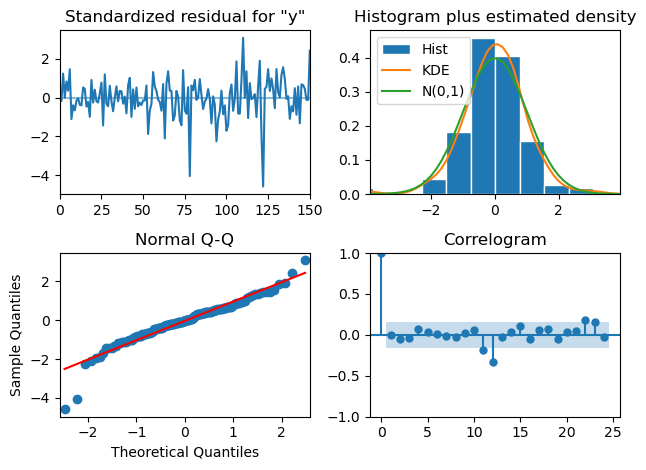

In [11]:
arima.plot_diagnostics(lags=24)
plt.tight_layout()
plt.show();


In [12]:
# Тест Льюнга-Бокса на отсутствие автокорреляции в остатках
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(arima.resid, period=12,model_df=2+2)
lb_test['check'] = lb_test['lb_pvalue']>0.05
print(lb_test)


      lb_stat  lb_pvalue  check
1    0.005585        NaN  False
2    0.351534        NaN  False
3    0.549899        NaN  False
4    1.475600        NaN  False
5    1.653818   0.198440   True
6    1.667240   0.434474   True
7    1.707204   0.635333   True
8    1.784282   0.775357   True
9    1.871465   0.866629   True
10   2.431324   0.876073   True
11   8.195980   0.315630   True
12  26.397733   0.000898  False
13  26.461586   0.001716  False
14  26.682866   0.002923  False
15  28.604707   0.002613  False
16  29.149696   0.003743  False
17  29.912011   0.004849  False
18  30.899876   0.005725  False
19  31.211901   0.008229  False
20  31.349613   0.012137  False
21  31.828724   0.015802  False
22  37.650488   0.004307  False
23  42.059534   0.001740  False
24  42.149810   0.002644  False


Так как тест Льюнга — Бокса проверяет нулевую гипотезу о нескоррелированности ряда построеннаяя модель ARIMA не полностью объясняет сезонные колебания.
Хотя остатки дают симметричное распределение, близкое к нормальному

#### Модель SARIMA
Настройка модели SARIMA описана тут: https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/

In [14]:
# Автоматический подбор параметров
auto_model = pm.auto_arima(ts,
start_p=0, max_p=5,
start_q=0, max_q=5,
start_P=0, max_P=2,
start_Q=0, max_Q=2,
d=None, max_d=2,
D=None, max_D=2,
m=12,
information_criterion = 'bic',
seasonal=True,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(auto_model.summary())


Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=3341.415, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=3170.948, Time=0.87 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=3199.433, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=3336.360, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=3333.203, Time=0.15 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=3168.919, Time=1.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : BIC=3173.726, Time=3.07 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=3167.726, Time=1.75 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=3241.367, Time=0.91 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : BIC=3173.632, Time=1.41 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : BIC=3261.420, Time=0.44 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : BIC=inf, Time=2.56 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=3181.421, Time=0.73 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : BIC=3152.352, Time=0.84 sec
 ARIMA(2,1,0)(0,0,1)[12]

In [15]:
auto_model.order, auto_model.seasonal_order

((4, 1, 0), (2, 0, 0, 12))

Наилучшая модель по критерию BIC:
$\text{SARIMA}(4,1,0)(2,0,0)_{12}$

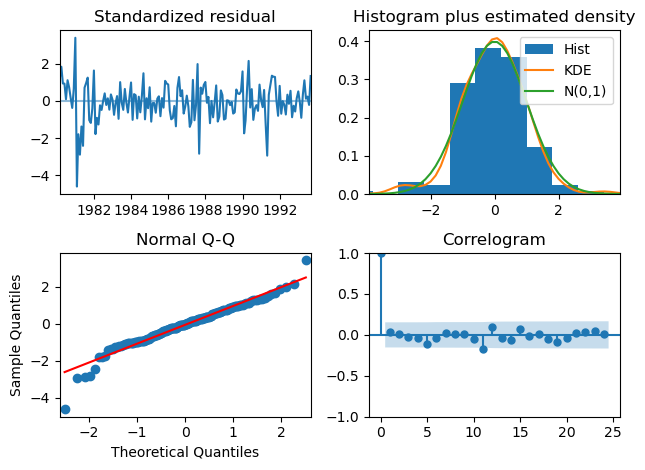

In [16]:
auto_model.plot_diagnostics(lags=24)
plt.tight_layout()
plt.show();


In [17]:
# Тест Льюнга-Бокса на отсутствие автокорреляции в остатках

lb_test = acorr_ljungbox(auto_model.resid(), period=12, model_df = auto_model.df_model())
lb_test['check'] = lb_test['lb_pvalue']>0.05
print(lb_test)


      lb_stat  lb_pvalue  check
1    2.802191        NaN  False
2    4.633142        NaN  False
3    4.770560        NaN  False
4    5.063605        NaN  False
5    5.755938        NaN  False
6    5.758381        NaN  False
7    6.264549        NaN  False
8    6.359805        NaN  False
9    6.373658   0.011583  False
10   6.795134   0.033455  False
11   8.177368   0.042485  False
12   8.735459   0.068063   True
13  10.661750   0.058515   True
14  14.253871   0.026925  False
15  14.267145   0.046629  False
16  14.750507   0.064182   True
17  15.007149   0.090740   True
18  15.127199   0.127493   True
19  15.491291   0.161092   True
20  16.216119   0.181537   True
21  16.220977   0.237403   True
22  16.222957   0.299949   True
23  16.799155   0.331012   True
24  17.013646   0.384715   True


Итак, видим, что  остатки случайны и близки к нормальному распределению


### Прогнозирование

In [30]:
tested = auto_model.predict_in_sample() # прогноз на обучающих данных 
predicted = auto_model.predict(12) # прогноз в будущее
predicted

1993-09-30    28887.933351
1993-10-31    27374.525715
1993-11-30    31819.999139
1993-12-31    38434.691321
1994-01-31    22109.436875
1994-02-28    23908.497236
1994-03-31    26666.816599
1994-04-30    28200.928477
1994-05-31    28159.137668
1994-06-30    27632.188262
1994-07-31    31878.824542
1994-08-31    30680.595847
Freq: M, dtype: float64

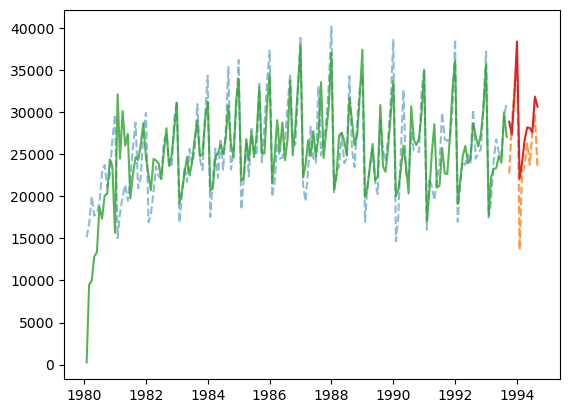

In [32]:
plt.plot(ts, alpha=0.5, ls='--')
plt.plot(ts_test, alpha=0.8, ls='--')
plt.plot(tested, alpha=0.8,)
plt.plot(predicted)
plt.draw();


In [37]:
MAE = mean_absolute_error(y_true=ts_test.values, y_pred = predicted.values)

In [38]:
print(f'MAE = {MAE}')

MAE = 3177.293776905923


## 2.2. Задание 2

1. Попробуйте спрогнозировать продажи круассанов с помощью SARIMA. Сначала, без использования `auto_arima`, а потом с использованием его. Оцените адекватность моделей.
2. Оцените качество прогноза лучшей модели c горизонтом 1 недели методом кроссвалидации по временному ряду
3. Определите в какой момент времени ухудшается качество прогноза.
4. При прогнозировании чаще всего интересно не отдельное значение, а доверительный интервал с заданной ошибкой $\alpha$ Как реализовать  вычисление доверительных интервалов в прогнозе из видов прогнозов.
5. Целесообразно ли предварительного применения преобразования  Бокса-Кокса к данным.